# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

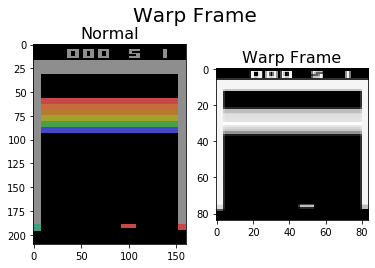

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

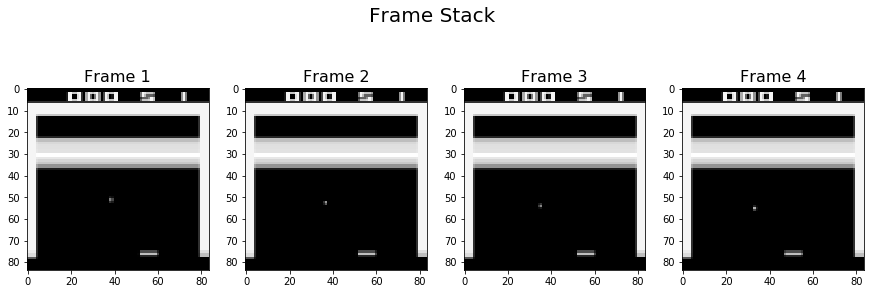

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [15]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error"#Huber()################################################################### MSE probieren
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [16]:
DQN.summary()
TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [17]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [19]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [24]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

In [21]:
EPSILON = 1.0
EPSILON_MIN = 0.02 #0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [22]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

0.0

# **Training des Agenten**

In [32]:
from datetime import datetime
start_time = datetime.now()

EPISODES = 10000#15000
#REWARD_LIST = []
#MEAN_LIST = []
#BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
#EPSILON_LIST = []
#STEPS = 0
SYNC = 1000#10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2), "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Episode: 1 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020086204971553986
Episode: 2 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020086118809670556
Episode: 3 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020086008648112615
Episode: 4 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02008596737386813
Episode: 5 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020085891755855935
Episode: 6 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020085802474864006
Episode: 7 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02008568414911224
Episode: 8 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020085584813125282
Episode: 9 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02008554203141504
Episode: 10 	Reward: 1.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020085512952068126
Episode: 11 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020085429190425007
Episode: 12 	Reward: 5.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02008530796706356
Episode: 13 	Rewa

Episode: 101 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02007975088594622
Episode: 102 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020079674361833163
Episode: 103 	Reward: 6.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020079569261057317
Episode: 104 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020079513582064498
Episode: 105 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.0200794674775585
Episode: 106 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020079456352890386
Episode: 107 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020079445229779617
Episode: 108 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02007943887441545
Episode: 109 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020079335670975484
Episode: 110 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020079264300992914
Episode: 111 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020079185076310863
Episode: 112 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020079158157961

Episode: 199 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.0200739439852618
Episode: 200 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020073858259969178
Episode: 201 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02007380952960039
Episode: 202 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020073797721020366
Episode: 203 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02007372101128648
Episode: 204 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020073687107419774
Episode: 205 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020073622291288527
Episode: 206 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020073544293006153
Episode: 207 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0200734649080453
Episode: 208 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020073381205769493
Episode: 209 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020073354793289946
Episode: 210 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02007334452433773

Episode: 299 	Reward: 6.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020068698533368103
Episode: 300 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020068662819417184
Episode: 301 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020068585960108683
Episode: 302 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02006850096622525
Episode: 303 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020068440711890765
Episode: 304 	Reward: 5.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020068349062755467
Episode: 305 	Reward: 3.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.02006829713720198
Episode: 306 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020068286210534185
Episode: 307 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020068260266703823
Episode: 308 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020068250710935404
Episode: 309 	Reward: 12.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020068042182970442
Episode: 310 	Reward: 2.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020067985051

Episode: 397 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020063646723741523
Episode: 398 	Reward: 5.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020063557680672976
Episode: 399 	Reward: 3.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02006350050449351
Episode: 400 	Reward: 0.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020063490345225553
Episode: 401 	Reward: 7.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020063392645342126
Episode: 402 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02006334828601796
Episode: 403 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02006328496939553
Episode: 404 	Reward: 5.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020063214129907324
Episode: 405 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02006317115891078
Episode: 406 	Reward: 2.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02006312695457287
Episode: 407 	Reward: 0.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02006311685506812
Episode: 408 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02006303863867202

Episode: 495 	Reward: 2.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02005890511038505
Episode: 496 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020058867423175596
Episode: 497 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020058799176555404
Episode: 498 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020058779188233584
Episode: 499 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02005870399900402
Episode: 500 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020058627733388703
Episode: 501 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02005860077083321
Episode: 502 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020058546882916285
Episode: 503 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020058487195541444
Episode: 504 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020058466143940565
Episode: 505 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020058406538877496
Episode: 506 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02005838551630

Episode: 594 	Reward: 6.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020054094247571222
Episode: 595 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020054069369939632
Episode: 596 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02005403369592919
Episode: 597 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020053996965505718
Episode: 598 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02005398832668236
Episode: 599 	Reward: 7.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020053904170551588
Episode: 600 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020053841677966453
Episode: 601 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020053798621848824
Episode: 602 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.0200537362516292
Episode: 603 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020053707241886657
Episode: 604 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200536997233991
Episode: 605 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02005363210435655

Episode: 692 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02005015247427341
Episode: 693 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020050103348923976
Episode: 694 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02005008631668099
Episode: 695 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020050045262735728
Episode: 696 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02005003925766451
Episode: 697 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020050004242440904
Episode: 698 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020049980246164098
Episode: 699 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020049957260537963
Episode: 700 	Reward: 3.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.020049913317486467
Episode: 701 	Reward: 6.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02004984348773422
Episode: 702 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020049789685825728
Episode: 703 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020049710086025

Episode: 790 	Reward: 5.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02004652118734494
Episode: 791 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020046480266707797
Episode: 792 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020046432881006573
Episode: 793 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02004642638085825
Episode: 794 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020046404101542903
Episode: 795 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020046378122520844
Episode: 796 	Reward: 4.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020046324355089858
Episode: 797 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020046308607486372
Episode: 798 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020046257696024576
Episode: 799 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020046205916407028
Episode: 800 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200461828192236
Episode: 801 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020046144964834

Episode: 888 	Reward: 5.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02004330585523299
Episode: 889 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020043285073410515
Episode: 890 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02004323229782061
Episode: 891 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02004318822335863
Episode: 892 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020043139016837047
Episode: 893 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020043096761309137
Episode: 894 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02004307521831468
Episode: 895 	Reward: 6.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02004300635307226
Episode: 896 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020042978837812118
Episode: 897 	Reward: 3.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020042935880456563
Episode: 898 	Reward: 3.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02004289210818615
Episode: 899 	Reward: 5.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.02004283467125252

Episode: 987 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02004014620240131
Episode: 988 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02004013255501268
Episode: 989 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02004008763171281
Episode: 990 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02004007240130672
Episode: 991 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02004002674479838
Episode: 992 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02003997714239468
Episode: 993 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020039970746563576
Episode: 994 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020039939581537197
Episode: 995 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02003992600438772
Episode: 996 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020039912431853688
Episode: 997 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02003987174192859
Episode: 998 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020039829500274175


Episode: 1085 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020037244632878533
Episode: 1086 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02003723867421398
Episode: 1087 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020037191039203896
Episode: 1088 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020037185089113643
Episode: 1089 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02003715312368411
Episode: 1090 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02003713975096682
Episode: 1091 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02003709669383366
Episode: 1092 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02003705516879493
Episode: 1093 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020037006288240386
Episode: 1094 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020036993708241104
Episode: 1095 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020036980392903043
Episode: 1096 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0200

Episode: 1182 	Reward: 3.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020034435494546973
Episode: 1183 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020034412086370364
Episode: 1184 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020034406580876993
Episode: 1185 	Reward: 0.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.02003440176429284
Episode: 1186 	Reward: 2.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020034379066619465
Episode: 1187 	Reward: 2.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.020034359819731788
Episode: 1188 	Reward: 6.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.02003430969099786
Episode: 1189 	Reward: 3.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.0200342795117506
Episode: 1190 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020034240455373567
Episode: 1191 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020034228815597615
Episode: 1192 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200341911846013
Episode: 1193 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02003

Episode: 1279 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020032065088436864
Episode: 1280 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020032043291588496
Episode: 1281 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020032028555064026
Episode: 1282 	Reward: 0.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020032024071380182
Episode: 1283 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02003200294246638
Episode: 1284 	Reward: 2.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020031976710810008
Episode: 1285 	Reward: 5.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02003193516809457
Episode: 1286 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020031907715656248
Episode: 1287 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020031893679349575
Episode: 1288 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.02003188283734184
Episode: 1289 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020031857978424952
Episode: 1290 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02

Episode: 1376 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020029733306565285
Episode: 1377 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.0200297285496168
Episode: 1378 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02002969052141653
Episode: 1379 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020029653134917988
Episode: 1380 	Reward: 7.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020029602767413137
Episode: 1381 	Reward: 0.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020029598031349245
Episode: 1382 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020029577319977128
Episode: 1383 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020029551303384525
Episode: 1384 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020029521176422437
Episode: 1385 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020029488131213614
Episode: 1386 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02002947692785253
Episode: 1387 	Reward: 3.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020

Episode: 1473 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020027546840610738
Episode: 1474 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020027533621300133
Episode: 1475 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020027524261460154
Episode: 1476 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020027492351828026
Episode: 1477 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02002748245636266
Episode: 1478 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02002745059519633
Episode: 1479 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020027426449298308
Episode: 1480 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020027396844722413
Episode: 1481 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020027386983633415
Episode: 1482 	Reward: 6.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020027346480877072
Episode: 1483 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02002733718465402
Episode: 1484 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02

Episode: 1570 	Reward: 4.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020025677313289022
Episode: 1571 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02002564805783065
Episode: 1572 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02002561832333291
Episode: 1573 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020025593229673944
Episode: 1574 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02002555998009228
Episode: 1575 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.0200255446487041
Episode: 1576 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020025541072703608
Episode: 1577 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020025529326511995
Episode: 1578 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02002551758572239
Episode: 1579 	Reward: 8.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020025464564305477
Episode: 1580 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020025460490301118
Episode: 1581 	Reward: 10.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.0200

Episode: 1667 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020023688930005522
Episode: 1668 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020023685140079923
Episode: 1669 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020023669039659433
Episode: 1670 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02002365200408442
Episode: 1671 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020023626946243094
Episode: 1672 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.0200235948354365
Episode: 1673 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020023591060564828
Episode: 1674 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020023579267982938
Episode: 1675 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02002356088332486
Episode: 1676 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020023536863476073
Episode: 1677 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02002352886230277
Episode: 1678 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0200

Episode: 1764 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020022029178072345
Episode: 1765 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020022012442257424
Episode: 1766 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02002198076715212
Episode: 1767 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020021960554145752
Episode: 1768 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02002193816580052
Episode: 1769 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020021914047085865
Episode: 1770 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020021902654743646
Episode: 1771 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02002187682485368
Episode: 1772 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02002185889321028
Episode: 1773 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020021847092594396
Episode: 1774 	Reward: 3.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020021827002512066
Episode: 1775 	Reward: 4.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020

Episode: 1861 	Reward: 8.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020020353397487308
Episode: 1862 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.0200203403754804
Episode: 1863 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020020326955261743
Episode: 1864 	Reward: 3.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02002030582621728
Episode: 1865 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020020290399652193
Episode: 1866 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02002028350208896
Episode: 1867 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020020283096422977
Episode: 1868 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020020259986868003
Episode: 1869 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020020239737007752
Episode: 1870 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020020232452013807
Episode: 1871 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020020212633923284
Episode: 1872 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020

Episode: 1958 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02001888084376472
Episode: 1959 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02001887971094808
Episode: 1960 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02001887102827821
Episode: 1961 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02001884990455803
Episode: 1962 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020018825415603375
Episode: 1963 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020018806599597344
Episode: 1964 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020018790057069476
Episode: 1965 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02001876827324034
Episode: 1966 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02001874763949042
Episode: 1967 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02001872290893205
Episode: 1968 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02001870831075711
Episode: 1969 	Reward: 4.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.0200186

Episode: 2055 	Reward: 6.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.0200174658553237
Episode: 2056 	Reward: 4.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020017445606678008
Episode: 2057 	Reward: 1.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020017439327389943
Episode: 2058 	Reward: 2.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020017425033002984
Episode: 2059 	Reward: 3.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020017407268530744
Episode: 2060 	Reward: 2.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02001739543561179
Episode: 2061 	Reward: 0.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020017393000421272
Episode: 2062 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020017381524828355
Episode: 2063 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020017361026725317
Episode: 2064 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020017338472054287
Episode: 2065 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020017338125288314
Episode: 2066 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02

Episode: 2152 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020016106579460388
Episode: 2153 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02001609885015743
Episode: 2154 	Reward: 6.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02001607568449648
Episode: 2155 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02001607311259272
Episode: 2156 	Reward: 9.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020016036186914565
Episode: 2157 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.0200160307355378
Episode: 2158 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.0200160224017223
Episode: 2159 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02001600446667787
Episode: 2160 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020015987510931327
Episode: 2161 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020015971850845308
Episode: 2162 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02001596099367859
Episode: 2163 	Reward: 5.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.02001593

Episode: 2249 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02001487062589407
Episode: 2250 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020014870328484525
Episode: 2251 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02001486824678426
Episode: 2252 	Reward: 2.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020014858436978974
Episode: 2253 	Reward: 6.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02001483586931054
Episode: 2254 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02001482341241295
Episode: 2255 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020014816595211316
Episode: 2256 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020014809781144872
Episode: 2257 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020014805042773087
Episode: 2258 	Reward: 1.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.02001479971391694
Episode: 2259 	Reward: 3.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020014784921600415
Episode: 2260 	Reward: 0.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.0200

Episode: 2346 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02001384200556763
Episode: 2347 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02001382651119986
Episode: 2348 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020013808824587368
Episode: 2349 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020013797781945345
Episode: 2350 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020013791160599263
Episode: 2351 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02001377544763427
Episode: 2352 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020013769112385577
Episode: 2353 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020013755350155454
Episode: 2354 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020013748474199507
Episode: 2355 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020013732535215836
Episode: 2356 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020013717437732236
Episode: 2357 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02

Episode: 2443 	Reward: 7.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020012757608652145
Episode: 2444 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020012748681450972
Episode: 2445 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020012736958057626
Episode: 2446 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020012732373577983
Episode: 2447 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020012714052154622
Episode: 2448 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020012709475919616
Episode: 2449 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020012700836413756
Episode: 2450 	Reward: 6.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02001268256037123
Episode: 2451 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020012672164934436
Episode: 2452 	Reward: 2.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.0200126620312565
Episode: 2453 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020012646087144016
Episode: 2454 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02

Episode: 2540 	Reward: 8.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020011734671675063
Episode: 2541 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02001173068256488
Episode: 2542 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02001171872336889
Episode: 2543 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020011712631216837
Episode: 2544 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020011704201157544
Episode: 2545 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020011688761804234
Episode: 2546 	Reward: 1.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020011684788300753
Episode: 2547 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020011679414534196
Episode: 2548 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020011668441042883
Episode: 2549 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020011666574241662
Episode: 2550 	Reward: 5.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020011651650579814
Episode: 2551 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0

Episode: 2637 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02001091619919481
Episode: 2638 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020010902235398576
Episode: 2639 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020010891992112402
Episode: 2640 	Reward: 6.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020010875666371598
Episode: 2641 	Reward: 7.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020010857844896354
Episode: 2642 	Reward: 2.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02001085154917225
Episode: 2643 	Reward: 3.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020010843305128014
Episode: 2644 	Reward: 8.0 	Mean: 3.9 	TRAIN START: True 	Epsi: 0.020010822289507808
Episode: 2645 	Reward: 3.0 	Mean: 4.1 	TRAIN START: True 	Epsi: 0.02001080931054933
Episode: 2646 	Reward: 3.0 	Mean: 4.3 	TRAIN START: True 	Epsi: 0.020010798290673662
Episode: 2647 	Reward: 6.0 	Mean: 4.6 	TRAIN START: True 	Epsi: 0.020010781242845728
Episode: 2648 	Reward: 3.0 	Mean: 4.4 	TRAIN START: True 	Epsi: 0.02

Episode: 2734 	Reward: 1.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020010052565249556
Episode: 2735 	Reward: 3.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.02001004372288335
Episode: 2736 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02001004050940621
Episode: 2737 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020010031878280037
Episode: 2738 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020010024056465882
Episode: 2739 	Reward: 1.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02001001944646029
Episode: 2740 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020010009231835244
Episode: 2741 	Reward: 5.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020009997227960808
Episode: 2742 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020009985837614663
Episode: 2743 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000998244300699
Episode: 2744 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020009978849974294
Episode: 2745 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020

Episode: 2831 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020009337773594513
Episode: 2832 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020009336466397715
Episode: 2833 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020009326015408994
Episode: 2834 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000931538980917
Episode: 2835 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020009303287670515
Episode: 2836 	Reward: 0.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020009301799263562
Episode: 2837 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020009297335471313
Episode: 2838 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020009286185360152
Episode: 2839 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.0200092848853852
Episode: 2840 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000928339992238
Episode: 2841 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020009280244102926
Episode: 2842 	Reward: 7.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020

Episode: 2930 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020008667911300574
Episode: 2931 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020008661845885806
Episode: 2932 	Reward: 10.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020008639008770923
Episode: 2933 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020008634863041767
Episode: 2934 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020008633481574202
Episode: 2935 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020008630374080218
Episode: 2936 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020008617782927837
Episode: 2937 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020008608480746357
Episode: 2938 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000860710349962
Episode: 2939 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000860159671574
Episode: 2940 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020008596093455074
Episode: 2941 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.

Episode: 3027 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020008083038474324
Episode: 3028 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000807609004949
Episode: 3029 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000806930898229
Episode: 3030 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000806188863191
Episode: 3031 	Reward: 7.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020008049160905428
Episode: 3032 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020008048034101777
Episode: 3033 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020008039990090352
Episode: 3034 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020008034685447616
Episode: 3035 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020008030669109063
Episode: 3036 	Reward: 6.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020008019434038692
Episode: 3037 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000800917572984
Episode: 3038 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020

Episode: 3124 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020007505738419962
Episode: 3125 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000749838639939
Episode: 3126 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020007494788037594
Episode: 3127 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020007491191402597
Episode: 3128 	Reward: 6.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020007480860688293
Episode: 3129 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020007473084637427
Episode: 3130 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000746501806275
Episode: 3131 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000745740762631
Episode: 3132 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020007451295058553
Episode: 3133 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020007450251950262
Episode: 3134 	Reward: 11.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.0200074289746707
Episode: 3135 	Reward: 0.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020

Episode: 3221 	Reward: 7.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020006955048860933
Episode: 3222 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000695185027419
Episode: 3223 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020006946985681805
Episode: 3224 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020006939764572323
Episode: 3225 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020006937266706718
Episode: 3226 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020006931857748454
Episode: 3227 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000692950131744
Episode: 3228 	Reward: 6.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020006919114857254
Episode: 3229 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020006918007887436
Episode: 3230 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000691690109472
Episode: 3231 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020006913028714476
Episode: 3232 	Reward: 0.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.02

Episode: 3318 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020006468005878974
Episode: 3319 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020006465807130783
Episode: 3320 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020006458569480638
Episode: 3321 	Reward: 3.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000645288843952
Episode: 3322 	Reward: 6.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020006443345228348
Episode: 3323 	Reward: 1.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000644025316479
Episode: 3324 	Reward: 3.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020006434588234943
Episode: 3325 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000643227220009
Episode: 3326 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020006430342807854
Episode: 3327 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020006430214202283
Episode: 3328 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020006423658727658
Episode: 3329 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02

Episode: 3415 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020006011701684482
Episode: 3416 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020006004371880517
Episode: 3417 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000599657126857
Episode: 3418 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020005995731807356
Episode: 3419 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020005991416434176
Episode: 3420 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000598650548646
Episode: 3421 	Reward: 5.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020005978728085735
Episode: 3422 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020005975858984892
Episode: 3423 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020005969766716314
Episode: 3424 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000596511211381
Episode: 3425 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020005957481654835
Episode: 3426 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02

Episode: 3512 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000558390219814
Episode: 3513 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.0200055821156353
Episode: 3514 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000557486359982
Episode: 3515 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020005568623247837
Episode: 3516 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000556661890427
Episode: 3517 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020005562723634542
Episode: 3518 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000555705254918
Episode: 3519 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020005553163973556
Episode: 3520 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020005549500094547
Episode: 3521 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000554694791155
Episode: 3522 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020005539741564406
Episode: 3523 	Reward: 12.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.02000

Episode: 3609 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020005177632216188
Episode: 3610 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000517173307861
Episode: 3611 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020005165943980063
Episode: 3612 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020005165117495144
Episode: 3613 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200051593358019
Episode: 3614 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020005156756778813
Episode: 3615 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020005150160352748
Episode: 3616 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020005144601182058
Episode: 3617 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000514388098831
Episode: 3618 	Reward: 6.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020005136273675245
Episode: 3619 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020005131345218558
Episode: 3620 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020

Episode: 3706 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.0200047861572761
Episode: 3707 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02000478280813834
Episode: 3708 	Reward: 2.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020004780226119154
Episode: 3709 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020004778601118538
Episode: 3710 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020004775734817844
Episode: 3711 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.0200047749707614
Episode: 3712 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020004773252081307
Episode: 3713 	Reward: 3.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020004769625787892
Episode: 3714 	Reward: 4.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020004764763249902
Episode: 3715 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020004759239329026
Episode: 3716 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020004755053040654
Episode: 3717 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.0200

Episode: 3803 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000443260678766
Episode: 3804 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020004431099957528
Episode: 3805 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020004430479646958
Episode: 3806 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000442543177799
Episode: 3807 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020004419770849085
Episode: 3808 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000441464688737
Episode: 3809 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020004410499069078
Episode: 3810 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020004405650187473
Episode: 3811 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020004405033439622
Episode: 3812 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020004401510822105
Episode: 3813 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020004400014562804
Episode: 3814 	Reward: 8.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02

Episode: 3900 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020004092057298865
Episode: 3901 	Reward: 3.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000408804904708
Episode: 3902 	Reward: 0.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020004087722016235
Episode: 3903 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000408355466549
Episode: 3904 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000408298300785
Episode: 3905 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020004081105267583
Episode: 3906 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020004077107743528
Episode: 3907 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020004074254766763
Episode: 3908 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020004072706844078
Episode: 3909 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020004071322359127
Episode: 3910 	Reward: 1.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.02000406944998152
Episode: 3911 	Reward: 4.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020

Episode: 3997 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.0200038057300948
Episode: 3998 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020003801926266933
Episode: 3999 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020003799265849803
Episode: 4000 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000379470946516
Episode: 4001 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020003794102360216
Episode: 4002 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0200037934953524
Episode: 4003 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020003790916652418
Episode: 4004 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000378591594363
Episode: 4005 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020003781753725733
Episode: 4006 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020003779107424437
Episode: 4007 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000377412229355
Episode: 4008 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020003

Episode: 4094 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020003519460992124
Episode: 4095 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020003515521402393
Episode: 4096 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000351432632829
Episode: 4097 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020003511937398716
Episode: 4098 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020003508707902105
Episode: 4099 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020003507444994597
Episode: 4100 	Reward: 10.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020003498127588556
Episode: 4101 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020003495749670377
Episode: 4102 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020003495190395175
Episode: 4103 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020003493163772524
Episode: 4104 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000349148745626
Episode: 4105 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.

Episode: 4191 	Reward: 6.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020003254985596613
Episode: 4192 	Reward: 3.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020003251732237968
Episode: 4193 	Reward: 1.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000325056182505
Episode: 4194 	Reward: 0.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000325004177676
Episode: 4195 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020003248936950387
Episode: 4196 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000324848213105
Episode: 4197 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000324731288796
Episode: 4198 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020003246144065723
Episode: 4199 	Reward: 1.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.020003245105465806
Episode: 4200 	Reward: 3.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020003242704976054
Episode: 4201 	Reward: 2.0 	Mean: 1.3 	TRAIN START: True 	Epsi: 0.020003240824752484
Episode: 4202 	Reward: 1.0 	Mean: 1.1 	TRAIN START: True 	Epsi: 0.020

Episode: 4288 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020003026442540317
Episode: 4289 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020003024022354488
Episode: 4290 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020003023538549616
Episode: 4291 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020003020274890676
Episode: 4292 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020003019187787404
Episode: 4293 	Reward: 6.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020003014662400613
Episode: 4294 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020003012251635127
Episode: 4295 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000300954182825
Episode: 4296 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020003006233152345
Episode: 4297 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000300467031748
Episode: 4298 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020003000826799847
Episode: 4299 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.0

Episode: 4385 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020002804955994585
Episode: 4386 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020002803946392166
Episode: 4387 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020002802488719072
Episode: 4388 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020002801199870718
Episode: 4389 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000279968763113
Episode: 4390 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020002798400070982
Episode: 4391 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020002795267617404
Episode: 4392 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000279504400494
Episode: 4393 	Reward: 1.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.02000279409385151
Episode: 4394 	Reward: 3.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020002791636130477
Episode: 4395 	Reward: 2.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.02000278985005496
Episode: 4396 	Reward: 2.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.020

Episode: 4482 	Reward: 7.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020002610776928116
Episode: 4483 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020002608323950885
Episode: 4484 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020002607072255818
Episode: 4485 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000260665515763
Episode: 4486 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000260576904552
Episode: 4487 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020002603112516157
Episode: 4488 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020002600094656334
Episode: 4489 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020002598379160037
Episode: 4490 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020002598015412418
Episode: 4491 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020002595366787723
Episode: 4492 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000259246160413
Episode: 4493 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02

Episode: 4579 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002422325067572
Episode: 4580 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002420726860495
Episode: 4581 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020002418017164122
Episode: 4582 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002417146834612
Episode: 4583 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020002415986882544
Episode: 4584 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000241410314753
Episode: 4585 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020002413185962607
Episode: 4586 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.0200024120279113
Episode: 4587 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020002411159737533
Episode: 4588 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.02000240980986608
Episode: 4589 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020002407930947257
Episode: 4590 	Reward: 3.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020

Episode: 4676 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020002251435134965
Episode: 4677 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002249274794368
Episode: 4678 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020002248465201176
Episode: 4679 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020002245139933983
Episode: 4680 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020002243299673848
Episode: 4681 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002241774748603
Episode: 4682 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002241012674747
Episode: 4683 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020002239892448488
Episode: 4684 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000223787745217
Episode: 4685 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020002234880704652
Episode: 4686 	Reward: 6.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020002231932608295
Episode: 4687 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.

Episode: 4773 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020002082664014972
Episode: 4774 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000207999991042
Episode: 4775 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020002078378143065
Episode: 4776 	Reward: 7.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000207505539694
Episode: 4777 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020002074723414635
Episode: 4778 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020002073727786368
Episode: 4779 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020002073022838768
Episode: 4780 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020002070453883528
Episode: 4781 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020002069750048868
Episode: 4782 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000206875680724
Episode: 4783 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000206801218883
Episode: 4784 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020

Episode: 4870 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020001934962314626
Episode: 4871 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020001934304539268
Episode: 4872 	Reward: 6.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020001931173502737
Episode: 4873 	Reward: 7.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020001928008973817
Episode: 4874 	Reward: 2.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.02000192669837337
Episode: 4875 	Reward: 1.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020001926081928526
Episode: 4876 	Reward: 0.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000192577378007
Episode: 4877 	Reward: 9.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020001921503304262
Episode: 4878 	Reward: 0.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020001921426445666
Episode: 4879 	Reward: 1.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000192077327172
Episode: 4880 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000191939081271
Episode: 4881 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020

Episode: 4967 	Reward: 1.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.020001792457979194
Episode: 4968 	Reward: 4.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020001790379933437
Episode: 4969 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000178837583042
Episode: 4970 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000178637397074
Episode: 4971 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001784302978342
Episode: 4972 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001782804793165
Episode: 4973 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001781521635707
Episode: 4974 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.0200017798121956
Episode: 4975 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001779171578526
Episode: 4976 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001778886933847
Episode: 4977 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001778246649806
Episode: 4978 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020

Episode: 5064 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001659452702384
Episode: 5065 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000165766146091
Episode: 5066 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001657097951816
Episode: 5067 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000165686597434
Episode: 5068 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020001655706573997
Episode: 5069 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020001654912025546
Episode: 5070 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020001653224875873
Episode: 5071 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001651407328343
Episode: 5072 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001649459816955
Episode: 5073 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000164781118159
Episode: 5074 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001645604593353
Episode: 5075 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02

Episode: 5161 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001544820698165
Episode: 5162 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000154377057717
Episode: 5163 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020001542042522018
Episode: 5164 	Reward: 5.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020001539915970992
Episode: 5165 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000153970039785
Episode: 5166 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020001537454075482
Episode: 5167 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020001535702376495
Episode: 5168 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000153441292814
Episode: 5169 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001533584568836
Episode: 5170 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020001531592204216
Episode: 5171 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000153061229881
Episode: 5172 	Reward: 5.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020

Episode: 5258 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001432939387963
Episode: 5259 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001431535795235
Episode: 5260 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000142953304737
Episode: 5261 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020001429075669982
Episode: 5262 	Reward: 5.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020001427247623323
Episode: 5263 	Reward: 0.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000142701928197
Episode: 5264 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000142653417789
Episode: 5265 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000142513685919
Episode: 5266 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020001424481446994
Episode: 5267 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001424025685857
Episode: 5268 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001422346326563
Episode: 5269 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020

Episode: 5355 	Reward: 5.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020001331635452896
Episode: 5356 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001331156150413
Episode: 5357 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001329745872473
Episode: 5358 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020001329107747615
Episode: 5359 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000132841679125
Episode: 5360 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001326717505534
Episode: 5361 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000132650524771
Episode: 5362 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000132629302385
Episode: 5363 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000132520590935
Episode: 5364 	Reward: 7.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001323060813772
Episode: 5365 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001322584597605
Episode: 5366 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020

Episode: 5452 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020001236479032437
Episode: 5453 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000123546553522
Episode: 5454 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0200012350702495
Episode: 5455 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000123428005743
Episode: 5456 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001233021733622
Episode: 5457 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001232602577496
Episode: 5458 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001231345963846
Episode: 5459 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001230066029725
Episode: 5460 	Reward: 6.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020001228296009362
Episode: 5461 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001228222313813
Episode: 5462 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020001227853902383
Episode: 5463 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020

Episode: 5549 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000114546177271
Episode: 5550 	Reward: 4.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020001144133807422
Episode: 5551 	Reward: 3.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020001142967385914
Episode: 5552 	Reward: 2.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020001142167588706
Episode: 5553 	Reward: 2.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020001141505323578
Episode: 5554 	Reward: 1.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020001141140100313
Episode: 5555 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000114061529658
Episode: 5556 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020001140090734205
Episode: 5557 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000113933852258
Episode: 5558 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020001139315736036
Episode: 5559 	Reward: 3.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020001138176989768
Episode: 5560 	Reward: 4.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02

Episode: 5646 	Reward: 0.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000106571704111
Episode: 5647 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020001064630563923
Episode: 5648 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000106446023666
Episode: 5649 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000106352392369
Episode: 5650 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020001063141123987
Episode: 5651 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020001062460931352
Episode: 5652 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020001061165519377
Episode: 5653 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020001060147289307
Episode: 5654 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000105887587556
Episode: 5655 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020001058706468972
Episode: 5656 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000105800795324
Episode: 5657 	Reward: 6.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.0200

Episode: 5743 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000098924609184
Episode: 5744 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000988929583737
Episode: 5745 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000987842359277
Episode: 5746 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000098715111159
Episode: 5747 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.0200009860066802
Episode: 5748 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000984784789646
Episode: 5749 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000098468631609
Episode: 5750 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000098382017329
Episode: 5751 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000983682448105
Episode: 5752 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000983112077708
Episode: 5753 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000098203124899
Episode: 5754 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000

Episode: 5840 	Reward: 3.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.0200009156215549
Episode: 5841 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000915493376854
Episode: 5842 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000914688097057
Episode: 5843 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000914541758667
Episode: 5844 	Reward: 6.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000091329882726
Episode: 5845 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000912276505182
Episode: 5846 	Reward: 6.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020000910890898223
Episode: 5847 	Reward: 0.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000910763382423
Episode: 5848 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.0200009102170883
Episode: 5849 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000910089666826
Episode: 5850 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000909198215833
Episode: 5851 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.0200

Episode: 5937 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000084569868311
Episode: 5938 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000844836510236
Episode: 5939 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000844380421677
Episode: 5940 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000844262216693
Episode: 5941 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000844127145544
Episode: 5942 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000084330030616
Episode: 5943 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000084282819019
Episode: 5944 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000842086827633
Episode: 5945 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000084112739563
Episode: 5946 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000840824644265
Episode: 5947 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000840437953873
Episode: 5948 	Reward: 0.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020

Episode: 6034 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000078663403663
Episode: 6035 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000785879230317
Episode: 6036 	Reward: 6.0 	Mean: 3.8 	TRAIN START: True 	Epsi: 0.020000784748378634
Episode: 6037 	Reward: 4.0 	Mean: 4.2 	TRAIN START: True 	Epsi: 0.020000783948343377
Episode: 6038 	Reward: 3.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020000783274437623
Episode: 6039 	Reward: 3.0 	Mean: 3.8 	TRAIN START: True 	Epsi: 0.02000078266372177
Episode: 6040 	Reward: 2.0 	Mean: 3.8 	TRAIN START: True 	Epsi: 0.02000078202220058
Episode: 6041 	Reward: 1.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000078166255309
Episode: 6042 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000781021852522
Episode: 6043 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000078024122105
Episode: 6044 	Reward: 0.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000078011639244
Episode: 6045 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000

Episode: 6131 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000072951733434
Episode: 6132 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000072856957798
Episode: 6133 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.0200007279869554
Episode: 6134 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000727754036843
Episode: 6135 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000072740479873
Episode: 6136 	Reward: 5.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000072644525783
Episode: 6137 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000072621283254
Episode: 6138 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000725661120464
Episode: 6139 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000725385421622
Episode: 6140 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000725167838636
Episode: 6141 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.0200007249068252
Episode: 6142 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.02000072

Episode: 6228 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000680837140267
Episode: 6229 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000068053763782
Episode: 6230 	Reward: 5.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000679735077014
Episode: 6231 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000067930018574
Episode: 6232 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000678865572715
Episode: 6233 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000678281999296
Episode: 6234 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000677658266817
Episode: 6235 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000677292430137
Episode: 6236 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000676534287255
Episode: 6237 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000676304304695
Episode: 6238 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000676060878967
Episode: 6239 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.0

Episode: 6325 	Reward: 7.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000063430069836
Episode: 6326 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000633945589406
Episode: 6327 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000063317264738
Episode: 6328 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000632476540395
Episode: 6329 	Reward: 5.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020000631680121804
Episode: 6330 	Reward: 4.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020000631036136567
Episode: 6331 	Reward: 0.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020000630935178863
Episode: 6332 	Reward: 4.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020000630203718384
Episode: 6333 	Reward: 2.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020000629762730145
Episode: 6334 	Reward: 5.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020000628919413236
Episode: 6335 	Reward: 0.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000628818794178
Episode: 6336 	Reward: 0.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.0

Episode: 6422 	Reward: 4.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000059286287312
Episode: 6423 	Reward: 7.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000591820352152
Episode: 6424 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000591619167438
Episode: 6425 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000059120517893
Episode: 6426 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000059059064516
Episode: 6427 	Reward: 2.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000059016557294
Episode: 6428 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000058943422116
Episode: 6429 	Reward: 1.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000589163143772
Episode: 6430 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020000588421265692
Episode: 6431 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000588115366175
Episode: 6432 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000588033035786
Episode: 6433 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200

Episode: 6519 	Reward: 5.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02000055064104156
Episode: 6520 	Reward: 3.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020000550156690586
Episode: 6521 	Reward: 1.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.020000549892678743
Episode: 6522 	Reward: 1.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.020000549705747012
Episode: 6523 	Reward: 5.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02000054896963462
Episode: 6524 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000548355132812
Episode: 6525 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000054810294746
Episode: 6526 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000054746751666
Episode: 6527 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000547281409344
Episode: 6528 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000547018777307
Episode: 6529 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000054637367583
Episode: 6530 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.0200

Episode: 6616 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000512490989622
Episode: 6617 	Reward: 6.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000051173306396
Episode: 6618 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000051165119322
Episode: 6619 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000510955820557
Episode: 6620 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000510506377217
Episode: 6621 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020000510006326033
Episode: 6622 	Reward: 5.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020000509364122735
Episode: 6623 	Reward: 4.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.02000050876342755
Episode: 6624 	Reward: 1.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000508580305682
Episode: 6625 	Reward: 2.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000050820409547
Episode: 6626 	Reward: 5.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020000507493107545
Episode: 6627 	Reward: 0.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020

Episode: 6713 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000476745654513
Episode: 6714 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020000476211998287
Episode: 6715 	Reward: 1.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000047599299114
Episode: 6716 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000475441159397
Episode: 6717 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000474956456654
Episode: 6718 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000474424803204
Episode: 6719 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000474168682968
Episode: 6720 	Reward: 3.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000473628438667
Episode: 6721 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000047355266418
Episode: 6722 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000047301312174
Episode: 6723 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000472530894334
Episode: 6724 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02

Episode: 6810 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000441696559623
Episode: 6811 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000044125508384
Episode: 6812 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000441105082613
Episode: 6813 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200004407964171
Episode: 6814 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000440443920985
Episode: 6815 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000440100508672
Episode: 6816 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000439704596404
Episode: 6817 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000043930904029
Episode: 6818 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000438808513342
Episode: 6819 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000438255962795
Episode: 6820 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000043796680929
Episode: 6821 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.0200

Episode: 6907 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000407892283953
Episode: 6908 	Reward: 7.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000040724832301
Episode: 6909 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000040710174
Episode: 6910 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.0200004068331415
Episode: 6911 	Reward: 11.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.02000040564692145
Episode: 6912 	Reward: 0.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000405582023133
Episode: 6913 	Reward: 4.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020000405128025554
Episode: 6914 	Reward: 2.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.02000040485263214
Episode: 6915 	Reward: 4.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020000404423715715
Episode: 6916 	Reward: 4.0 	Mean: 4.0 	TRAIN START: True 	Epsi: 0.020000403938698324
Episode: 6917 	Reward: 1.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020000403801382512
Episode: 6918 	Reward: 5.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.0200004

Episode: 7004 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000378646529336
Episode: 7005 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000378252941646
Episode: 7006 	Reward: 5.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000037779931035
Episode: 7007 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000377497191767
Episode: 7008 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000377361317236
Episode: 7009 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000377134968356
Episode: 7010 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000037695398701
Episode: 7011 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000376622413416
Episode: 7012 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000037608798912
Episode: 7013 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000376027819854
Episode: 7014 	Reward: 6.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000375509259354
Episode: 7015 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02

Episode: 7101 	Reward: 5.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000035147659734
Episode: 7102 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000351195528503
Episode: 7103 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000351097207523
Episode: 7104 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000351041036462
Episode: 7105 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000350921702797
Episode: 7106 	Reward: 8.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000035017853682
Episode: 7107 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000034995449426
Episode: 7108 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000349562764634
Episode: 7109 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000034955577345
Episode: 7110 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000034912957544
Episode: 7111 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000034893411761
Episode: 7112 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000

Episode: 7198 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000327144879593
Episode: 7199 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000326994427553
Episode: 7200 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000032698788773
Episode: 7201 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000326798289742
Episode: 7202 	Reward: 5.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000326360673303
Episode: 7203 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000032623667981
Episode: 7204 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000326125778192
Episode: 7205 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000325656495035
Episode: 7206 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000032550021743
Episode: 7207 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000325389566167
Episode: 7208 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000032503183443
Episode: 7209 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020

Episode: 7295 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000304162813762
Episode: 7296 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000030382841862
Episode: 7297 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000303567238503
Episode: 7298 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000303457973965
Episode: 7299 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000030325775778
Episode: 7300 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000030315466767
Episode: 7301 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000302809268265
Episode: 7302 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000030246426239
Episode: 7303 	Reward: 6.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000302035067936
Episode: 7304 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000030193239347
Episode: 7305 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000301552198226
Episode: 7306 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.0200

Episode: 7392 	Reward: 0.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020000281570575842
Episode: 7393 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000281379172934
Episode: 7394 	Reward: 3.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000281092312503
Episode: 7395 	Reward: 5.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000280749588987
Episode: 7396 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020000280609249278
Episode: 7397 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020000280468979725
Episode: 7398 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.02000028037363648
Episode: 7399 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000280188650934
Episode: 7400 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000279858223315
Episode: 7401 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000027981344958
Episode: 7402 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000027957291346
Episode: 7403 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02

Episode: 7489 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000262104460795
Episode: 7490 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000026201536043
Episode: 7491 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000026192629035
Episode: 7492 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000261842487346
Episode: 7493 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000261575544173
Episode: 7494 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000261267067068
Episode: 7495 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000261178251363
Episode: 7496 	Reward: 4.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000026089111324
Episode: 7497 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000260797209346
Episode: 7498 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000260724196348
Episode: 7499 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000260484440393
Episode: 7500 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02

Episode: 7586 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000243813388056
Episode: 7587 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000243730505594
Episode: 7588 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000243574567977
Episode: 7589 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000243331115154
Episode: 7590 	Reward: 8.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000242859510395
Episode: 7591 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000024275267572
Episode: 7592 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000024263132972
Episode: 7593 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000024262162466
Episode: 7594 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000024253914733
Episode: 7595 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000242277346446
Episode: 7596 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000242001307643
Episode: 7597 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020

Episode: 7683 	Reward: 2.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.0200002264633518
Episode: 7684 	Reward: 5.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000226173664152
Episode: 7685 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000226096778175
Episode: 7686 	Reward: 1.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.020000226010877722
Episode: 7687 	Reward: 3.0 	Mean: 1.5 	TRAIN START: True 	Epsi: 0.020000225757887242
Episode: 7688 	Reward: 1.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.020000225681142608
Episode: 7689 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000225554796545
Episode: 7690 	Reward: 2.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000225383440026
Episode: 7691 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000225306822682
Episode: 7692 	Reward: 5.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000225050119252
Episode: 7693 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000224762239383
Episode: 7694 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.0

Episode: 7780 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000209340712848
Episode: 7781 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000020917330725
Episode: 7782 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000020904365999
Episode: 7783 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000020891409309
Episode: 7784 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000208805486003
Episode: 7785 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000020869276148
Episode: 7786 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000020841746877
Episode: 7787 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.0200002081883356
Episode: 7788 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000207946977145
Episode: 7789 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000020787628719
Episode: 7790 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000207664361478
Episode: 7791 	Reward: 7.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.0200002

Episode: 7877 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000019359786166
Episode: 7878 	Reward: 0.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000019356688848
Episode: 7879 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000193446914203
Episode: 7880 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000193191732733
Episode: 7881 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000193180141578
Episode: 7882 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000193048823736
Episode: 7883 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000192882873115
Episode: 7884 	Reward: 2.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000192732483133
Episode: 7885 	Reward: 5.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000192474394565
Episode: 7886 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000192408964394
Episode: 7887 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000192378181424
Episode: 7888 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0

Episode: 7974 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.0200001799183487
Episode: 7975 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000179857186856
Episode: 7976 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000179677419568
Episode: 7977 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000179537325826
Episode: 7978 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000179304078946
Episode: 7979 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000017915352676
Episode: 7980 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000178967303946
Episode: 7981 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000017873122295
Episode: 7982 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000178581151763
Episode: 7983 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000017849545338
Episode: 7984 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.0200001782885187
Episode: 7985 	Reward: 3.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020000

Episode: 8071 	Reward: 4.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000016639477533
Episode: 8072 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000016630162034
Episode: 8073 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000166085568698
Episode: 8074 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000016597930794
Episode: 8075 	Reward: 0.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020000165952753376
Episode: 8076 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000165893021137
Episode: 8077 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000165836627098
Episode: 8078 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000016568412756
Episode: 8079 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000016552183665
Episode: 8080 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000165389472135
Episode: 8081 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000016522746985
Episode: 8082 	Reward: 4.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000

Episode: 8168 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000154826189494
Episode: 8169 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000015464978821
Episode: 8170 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000015451993693
Episode: 8171 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000154359319733
Episode: 8172 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000154334624216
Episode: 8173 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000154180366735
Episode: 8174 	Reward: 5.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000015398622181
Episode: 8175 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02000015382000646
Episode: 8176 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000153690851907
Episode: 8177 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000153500393362
Episode: 8178 	Reward: 4.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000153340835936
Episode: 8179 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020

Episode: 8265 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000143171488155
Episode: 8266 	Reward: 6.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000142956891908
Episode: 8267 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000142936879343
Episode: 8268 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000142819719145
Episode: 8269 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000142751182132
Episode: 8270 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000142696946988
Episode: 8271 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000014262561635
Episode: 8272 	Reward: 3.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000142528663896
Episode: 8273 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000014240899009
Episode: 8274 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000014224673634
Episode: 8275 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000014203920764
Episode: 8276 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020

Episode: 8362 	Reward: 3.0 	Mean: 4.1 	TRAIN START: True 	Epsi: 0.020000131950008798
Episode: 8363 	Reward: 2.0 	Mean: 4.0 	TRAIN START: True 	Epsi: 0.020000131860313294
Episode: 8364 	Reward: 0.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020000131839217332
Episode: 8365 	Reward: 2.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020000131733788135
Episode: 8366 	Reward: 4.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.020000131599488175
Episode: 8367 	Reward: 1.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020000131554751954
Episode: 8368 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000131425891448
Episode: 8369 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000013134180579
Episode: 8370 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000131192161444
Episode: 8371 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000131087249684
Episode: 8372 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000131016481678
Episode: 8373 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.

Episode: 8459 	Reward: 5.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.02000012223227519
Episode: 8460 	Reward: 1.0 	Mean: 3.6 	TRAIN START: True 	Epsi: 0.020000122190723283
Episode: 8461 	Reward: 2.0 	Mean: 3.8 	TRAIN START: True 	Epsi: 0.020000122105219707
Episode: 8462 	Reward: 0.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000012208812617
Episode: 8463 	Reward: 4.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.02000012195390307
Episode: 8464 	Reward: 2.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000121885628
Episode: 8465 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000121749192516
Episode: 8466 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000121732148823
Episode: 8467 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000012159831708
Episode: 8468 	Reward: 6.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000121413628037
Episode: 8469 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000121272869886
Episode: 8470 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000

Episode: 8556 	Reward: 5.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000113677231455
Episode: 8557 	Reward: 4.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000113549984225
Episode: 8558 	Reward: 0.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000011353408834
Episode: 8559 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000113479605057
Episode: 8560 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000011343875975
Episode: 8561 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000011340019713
Episode: 8562 	Reward: 4.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000113273260005
Episode: 8563 	Reward: 6.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000113098953436
Episode: 8564 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000011305824514
Episode: 8565 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000011301981187
Episode: 8566 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000112877496586
Episode: 8567 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.0200

Episode: 8653 	Reward: 5.0 	Mean: 3.7 	TRAIN START: True 	Epsi: 0.02000010574210201
Episode: 8654 	Reward: 4.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020000105617399917
Episode: 8655 	Reward: 4.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.02000010550128465
Episode: 8656 	Reward: 3.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020000105408484358
Episode: 8657 	Reward: 1.0 	Mean: 3.3 	TRAIN START: True 	Epsi: 0.020000105370544134
Episode: 8658 	Reward: 3.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020000105284175704
Episode: 8659 	Reward: 3.0 	Mean: 3.8 	TRAIN START: True 	Epsi: 0.020000105181047754
Episode: 8660 	Reward: 6.0 	Mean: 3.9 	TRAIN START: True 	Epsi: 0.02000010502339445
Episode: 8661 	Reward: 0.0 	Mean: 3.5 	TRAIN START: True 	Epsi: 0.020000105008692204
Episode: 8662 	Reward: 2.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000104939409333
Episode: 8663 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000010481984657
Episode: 8664 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020

Episode: 8750 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000098290082275
Episode: 8751 	Reward: 3.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000098201660994
Episode: 8752 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000098152572438
Episode: 8753 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000098095660453
Episode: 8754 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000097983895116
Episode: 8755 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000009789966519
Episode: 8756 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.0200000978487706
Episode: 8757 	Reward: 0.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.02000009783311605
Episode: 8758 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000097731422497
Episode: 8759 	Reward: 9.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000097514699392
Episode: 8760 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000097411388574
Episode: 8761 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020

Episode: 8847 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000090378203775
Episode: 8848 	Reward: 6.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.020000090249957803
Episode: 8849 	Reward: 3.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.02000009018139389
Episode: 8850 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000090130906447
Episode: 8851 	Reward: 5.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000090022814228
Episode: 8852 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020000089979613646
Episode: 8853 	Reward: 2.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000089916649956
Episode: 8854 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000089904062508
Episode: 8855 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000089846542314
Episode: 8856 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000089744175616
Episode: 8857 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000008967240899
Episode: 8858 	Reward: 8.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.0

Episode: 8944 	Reward: 2.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000008365516155
Episode: 8945 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.02000008362672363
Episode: 8946 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000083588264182
Episode: 8947 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000083496367643
Episode: 8948 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000008341124477
Episode: 8949 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000083354544403
Episode: 8950 	Reward: 5.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000083251248822
Episode: 8951 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000083237929688
Episode: 8952 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000008313976686
Episode: 8953 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000083064974732
Episode: 8954 	Reward: 5.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020000082958719582
Episode: 8955 	Reward: 1.0 	Mean: 2.9 	TRAIN START: True 	Epsi: 0.020

Episode: 9041 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000077577941644
Episode: 9042 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000007754071317
Episode: 9043 	Reward: 5.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000007744152455
Episode: 9044 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000007736257447
Episode: 9045 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.0200000773099858
Episode: 9046 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000007727134047
Episode: 9047 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000077243527793
Episode: 9048 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000077215725127
Episode: 9049 	Reward: 1.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000077189476242
Episode: 9050 	Reward: 4.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000077107698747
Episode: 9051 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000077096904424
Episode: 9052 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000

Episode: 9138 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000072231997734
Episode: 9139 	Reward: 0.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000007222188596
Episode: 9140 	Reward: 3.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000072152586222
Episode: 9141 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000072129501088
Episode: 9142 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000072047320308
Episode: 9143 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000007196235461
Episode: 9144 	Reward: 9.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.02000007179703139
Episode: 9145 	Reward: 4.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000071713795118
Episode: 9146 	Reward: 1.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000071689416574
Episode: 9147 	Reward: 1.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000071653580823
Episode: 9148 	Reward: 3.0 	Mean: 3.0 	TRAIN START: True 	Epsi: 0.020000071583394712
Episode: 9149 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.02

Episode: 9235 	Reward: 2.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000066546644952
Episode: 9236 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000066522692473
Episode: 9237 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000006647880198
Episode: 9238 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000066404387402
Episode: 9239 	Reward: 6.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.02000006631281255
Episode: 9240 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000066302203346
Episode: 9241 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000066250507792
Episode: 9242 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000006622798645
Episode: 9243 	Reward: 2.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000066176348762
Episode: 9244 	Reward: 6.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.02000006608773184
Episode: 9245 	Reward: 2.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000066044128326
Episode: 9246 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020

Episode: 9332 	Reward: 2.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.020000061680209735
Episode: 9333 	Reward: 4.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000061609934363
Episode: 9334 	Reward: 8.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000061490526952
Episode: 9335 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000061469623725
Episode: 9336 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000061447498645
Episode: 9337 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000061372578405
Episode: 9338 	Reward: 3.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000006130142749
Episode: 9339 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000006128058855
Episode: 9340 	Reward: 6.0 	Mean: 3.2 	TRAIN START: True 	Epsi: 0.02000006119118417
Episode: 9341 	Reward: 4.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.02000006113491417
Episode: 9342 	Reward: 2.0 	Mean: 3.4 	TRAIN START: True 	Epsi: 0.020000061082360743
Episode: 9343 	Reward: 1.0 	Mean: 3.1 	TRAIN START: True 	Epsi: 0.020

Episode: 9429 	Reward: 7.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000057050858798
Episode: 9430 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.0200000570223405
Episode: 9431 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000056975601345
Episode: 9432 	Reward: 4.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.02000005691296264
Episode: 9433 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000056874274984
Episode: 9434 	Reward: 4.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000056808339075
Episode: 9435 	Reward: 0.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000056799250467
Episode: 9436 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000056760640105
Episode: 9437 	Reward: 3.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000056699371705
Episode: 9438 	Reward: 1.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000056680097196
Episode: 9439 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000056660829237
Episode: 9440 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02

Episode: 9526 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000053055743747
Episode: 9527 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000005303770786
Episode: 9528 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000053018617722
Episode: 9529 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000052994234765
Episode: 9530 	Reward: 4.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000005293491445
Episode: 9531 	Reward: 0.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000052927504078
Episode: 9532 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000052898930944
Episode: 9533 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02000005289152561
Episode: 9534 	Reward: 4.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.02000005282915042
Episode: 9535 	Reward: 2.0 	Mean: 1.8 	TRAIN START: True 	Epsi: 0.020000052794294683
Episode: 9536 	Reward: 2.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020000052759461946
Episode: 9537 	Reward: 1.0 	Mean: 1.7 	TRAIN START: True 	Epsi: 0.020

Episode: 9623 	Reward: 9.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.02000004933842206
Episode: 9624 	Reward: 3.0 	Mean: 2.6 	TRAIN START: True 	Epsi: 0.020000049301925133
Episode: 9625 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000049269396598
Episode: 9626 	Reward: 2.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000049240828634
Episode: 9627 	Reward: 1.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000049223105127
Episode: 9628 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000004921621437
Episode: 9629 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000004920834041
Episode: 9630 	Reward: 0.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000049201451722
Episode: 9631 	Reward: 0.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02000004919358012
Episode: 9632 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000004914342825
Episode: 9633 	Reward: 5.0 	Mean: 1.6 	TRAIN START: True 	Epsi: 0.020000049075657094
Episode: 9634 	Reward: 1.0 	Mean: 1.4 	TRAIN START: True 	Epsi: 0.0200

Episode: 9720 	Reward: 1.0 	Mean: 2.7 	TRAIN START: True 	Epsi: 0.020000045660935516
Episode: 9721 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000045639936317
Episode: 9722 	Reward: 6.0 	Mean: 2.8 	TRAIN START: True 	Epsi: 0.020000045574262104
Episode: 9723 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000045553302766
Episode: 9724 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000045523247505
Episode: 9725 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000045506862085
Episode: 9726 	Reward: 2.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000045481385377
Episode: 9727 	Reward: 5.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000045423206447
Episode: 9728 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000045402316577
Episode: 9729 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.02000004536056565
Episode: 9730 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000045329730952
Episode: 9731 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.

Episode: 9817 	Reward: 2.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000042405714524
Episode: 9818 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000042356552415
Episode: 9819 	Reward: 2.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000042323527183
Episode: 9820 	Reward: 4.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000042276151368
Episode: 9821 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000042260934693
Episode: 9822 	Reward: 0.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000042254173483
Episode: 9823 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.020000042234741035
Episode: 9824 	Reward: 5.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000042179871544
Episode: 9825 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.020000042164689525
Episode: 9826 	Reward: 1.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.020000042150355966
Episode: 9827 	Reward: 1.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000004213012865
Episode: 9828 	Reward: 3.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.

Episode: 9914 	Reward: 3.0 	Mean: 2.4 	TRAIN START: True 	Epsi: 0.020000039339265006
Episode: 9915 	Reward: 2.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000039313309657
Episode: 9916 	Reward: 1.0 	Mean: 2.5 	TRAIN START: True 	Epsi: 0.020000039299159413
Episode: 9917 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000039255954102
Episode: 9918 	Reward: 2.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.0200000392253464
Episode: 9919 	Reward: 4.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000003919005947
Episode: 9920 	Reward: 1.0 	Mean: 2.3 	TRAIN START: True 	Epsi: 0.020000039176737112
Episode: 9921 	Reward: 3.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.02000003913757996
Episode: 9922 	Reward: 1.0 	Mean: 2.2 	TRAIN START: True 	Epsi: 0.020000039118798427
Episode: 9923 	Reward: 0.0 	Mean: 2.1 	TRAIN START: True 	Epsi: 0.02000003911332218
Episode: 9924 	Reward: 1.0 	Mean: 1.9 	TRAIN START: True 	Epsi: 0.02000003910002591
Episode: 9925 	Reward: 3.0 	Mean: 2.0 	TRAIN START: True 	Epsi: 0.02000

In [33]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung.csv",mode="w", index=False)

In [34]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

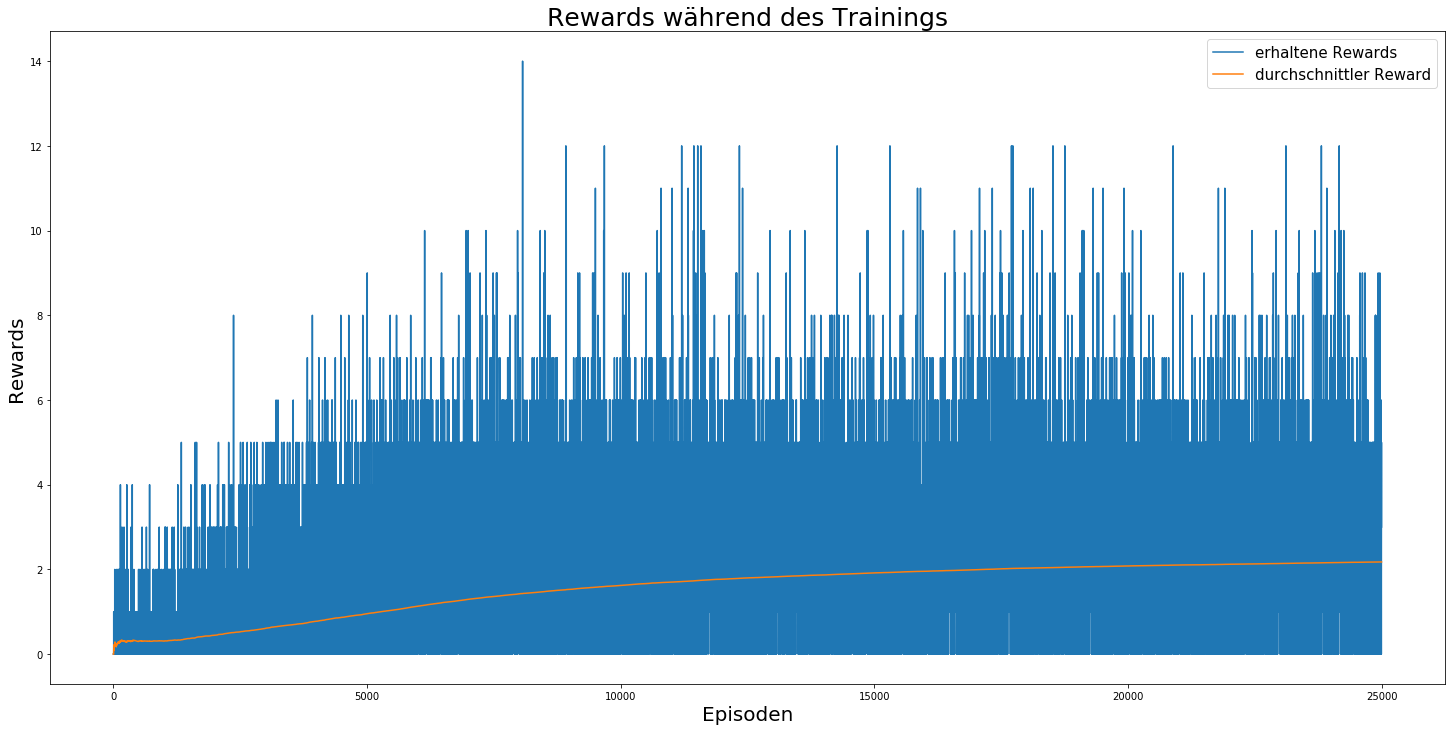

In [35]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [ ]:
!ls "WEIGHTS/"

In [ ]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

## Rendering a Game

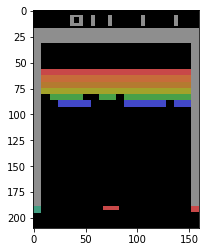

In [37]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)